## Housing Affordability by Sean Mannisto

This notebook:
- Creates the dataset for my Tableau visualization of housing affordability at:
https://public.tableau.com/app/profile/sean.mannisto/viz/HousingPricetoIncomeRatios/Sheet1

- Creates a color and size-coded scatterplot of all US counties and their relative housing affordability

- Calculates a Multiple Linear Regression Model

- Calculates and plots statistics

 Original Datasets:

 - Zillow "Housing Value Index All Homes Time Series Smoothed Seasonally Adjusted"
 https://www.zillow.com/research/data/

 - USDA "Unemployment and median household income for the U.S., States, and counties, 2000-2021" 
 https://www.ers.usda.gov/data-products/county-level-data-sets/county-level-data-sets-download-data/

- US Census "Annual County Resident Population Estimates by Age, Sex, Race, and Hispanic Origin: April 1, 2020 to July 1, 2021"
https://www2.census.gov/programs-surveys/popest/datasets/2020-2021/counties/asrh/

- US Census API American Community Survey

Federal Information Processing Standards (FIPS) code will be used as an index for each county


Load in libraries

In [181]:
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import requests
from requests.api import head
import statsmodels.api as sm


In [182]:
!pip install colorspacious
from colorspacious import cspace_converter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Set URLs, API key, 

In [396]:
# set Zillow Housing Value Index URL
zhvi_url = "https://files.zillowstatic.com/research/public_csvs/zhvi/County_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv?t=1670291347"

# set most recent ZHVI date
#mostrecentZHVI = "2022-12-31"

# set USDA URL
unemp_url = "https://www.ers.usda.gov/webdocs/DataFiles/48747/Unemployment.xlsx?v=7156"

# set my Census API key as a variable
api_key = "f229871d75fd694d4cd998c8f640e953e8b97157"

i=1

Load Zillow Housing Value Index data

In [184]:
# Download and read CSV
zhvi = pd.read_csv(zhvi_url)
zhvi.head()


,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,StateCodeFIPS,MunicipalCodeFIPS,2000-01-31,...,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30,2022-10-31,2022-11-30,2022-12-31
0,3101,0,Los Angeles County,county,CA,CA,"Los Angeles-Long Beach-Anaheim, CA",6,37,217219.0,...,849467.0,867274.0,882623.0,884311.0,883805.0,870575.0,859871.0,848269.0,846262.0,845596.0
1,139,1,Cook County,county,IL,IL,"Chicago-Naperville-Elgin, IL-IN-WI",17,31,173902.0,...,301166.0,303308.0,306745.0,309530.0,311511.0,311997.0,312558.0,313027.0,313775.0,312317.0
2,1090,2,Harris County,county,TX,TX,"Houston-The Woodlands-Sugar Land, TX",48,201,115286.0,...,269990.0,275086.0,280076.0,283929.0,286477.0,288032.0,288399.0,289143.0,289720.0,289591.0
3,2402,3,Maricopa County,county,AZ,AZ,"Phoenix-Mesa-Chandler, AZ",4,13,142739.0,...,457069.0,468583.0,477443.0,483784.0,481374.0,474787.0,464870.0,459841.0,454753.0,451699.0
4,2841,4,San Diego County,county,CA,CA,"San Diego-Chula Vista-Carlsbad, CA",6,73,225274.0,...,887685.0,906908.0,920069.0,919535.0,908231.0,897158.0,890169.0,885101.0,880975.0,874095.0


In [185]:
# Set most recent date to "recent_ZHVI" column
zhvi["recent_ZHVI"] = zhvi.iloc[:,-1]

Reformat FIPS and Fill NaN with blank strings

In [186]:
# Convert State and Municipal FIPS into single FIPS code. Format as 5 digits
zhvi["FIPS"] = zhvi["StateCodeFIPS"]*1000 + zhvi["MunicipalCodeFIPS"]
zhvi["FIPS"] = zhvi["FIPS"].apply(lambda x: '{0:0>5}'.format(x))

zhvi[['Metro']] = zhvi[['Metro']].fillna('')

Define Function to Plot County Housing Price over Time
Parameters:
  - Number of counties to plot
  - Number of columns wide
  - True or False: Top N Counties or Random Sample 

In [386]:
# Define the function to plot a selected number of counties
# 
# Note: Horizontal Scale changes to fully fit the available date range. 
#       Not all counties have the full time frame of data. 
#       Vertical scale is based the max price between the chosen counties
#       Scale can change between iterations of the plot function



def plot_ZHVI_county(num_counties:int, plot_width:int, top=True):
  if top == True:
    # Get the top populated counties
    sel_coun = zhvi[zhvi["SizeRank"] <= num_counties] 
  else:
    # Get a random sample of counties
    sel_coun = zhvi.sample(n=10)


# filter only the columns with valid date names
  sel_coun = sel_coun.filter(regex='\d{4}-\d{2}-\d{2}', axis=1)

# set the maximum value of y-axis
  ymax = np.nanmax(sel_coun.values)

# Calculate the number of rows for the plot
  plot_height = num_counties // plot_width + (num_counties % plot_width != 0)

# Calculate Figure Height
  fig_height = plot_height*5

# Create a figure with multiple subplots
  fig, axs = plt.subplots(nrows=plot_height, ncols=plot_width, figsize=(20, fig_height),
                       tight_layout=True)

# Plot the housing prices for each county on a separate subplot
  for i, county in enumerate(sel_coun.index[:num_counties]):
      row = i // plot_width
      col = i % plot_width
    # Extract the date values from the columns and use them as the x-axis
      x = [pd.to_datetime(col) for col in sel_coun.columns]
      #x = [pd.date_range(start='2000-01-01', end='2024-12-31')]
      #axs[row, col].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
      y = sel_coun.loc[county]
      
      axs[row, col].plot(x, y)

      # If there is an associated Metro Area, include it in the title 
      if zhvi.loc[county,'Metro'] != '':
        axs[row, col].set_title(zhvi.loc[county,'RegionName']+'\n'+zhvi.loc[county,'Metro'])
      # Otherwise just add the state
      else:
        axs[row, col].set_title(zhvi.loc[county,'RegionName']+", "+zhvi.loc[county,'State'])
      axs[row, col].set_ylim(0, ymax)
    
  plt.show()

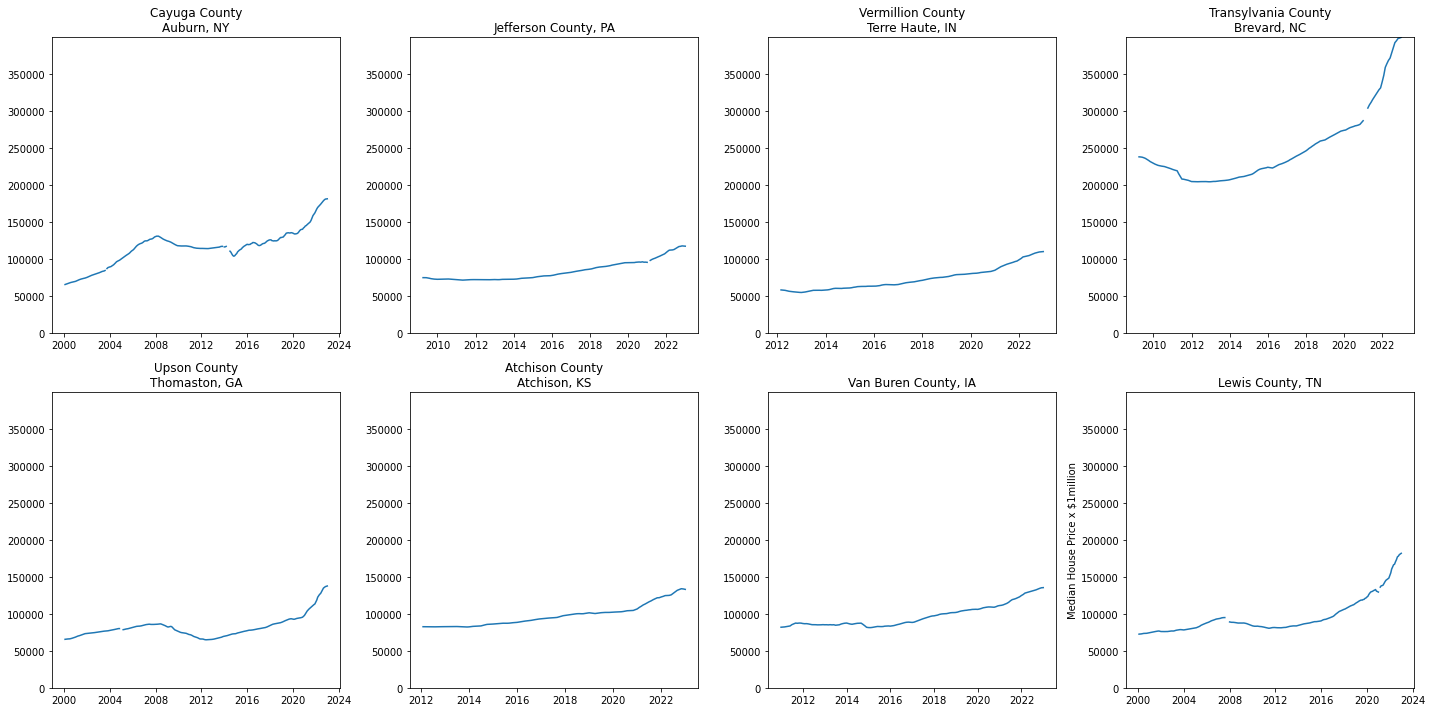

<Figure size 1440x1080 with 0 Axes>

In [395]:

plot_ZHVI_county(num_counties=8, plot_width=4, top=False)

plt.savefig('Sample_County_Price_Time.png')

Set relevant columns to new price dataframe and drop entries with no price data

In [189]:
# Only FIPS code, Name, Most Recent Price 
zhvi2 = zhvi[["FIPS", "RegionName", "recent_ZHVI"]]

# Drop null rows
zhvi2 = zhvi2.dropna(subset=['recent_ZHVI'])
#zhvi2.head()

Download and read in USDA employment and income CSV to dataframe

In [190]:
# The first 3 rows are source information, so header index is set to start at row 4.
unemployment = pd.read_excel(unemp_url, "Unemployment Med HH Income", header = 4)


In [191]:
# Shape of the dataframe
print("Dataframe Shape: "+ str(unemployment.shape))
# Preview
unemployment.head()

Dataframe Shape: (3277, 96)


,FIPS_code,State,Area_name,Rural_urban_continuum_code_2013,Urban_influence_code_2013,Metro_2013,Civilian_labor_force_2000,Employed_2000,Unemployed_2000,Unemployment_rate_2000,...,Civilian_labor_force_2020,Employed_2020,Unemployed_2020,Unemployment_rate_2020,Civilian_labor_force_2021,Employed_2021,Unemployed_2021,Unemployment_rate_2021,Median_Household_Income_2020,Med_HH_Income_Percent_of_State_Total_2020
0,0,US,United States,NaN,NaN,NaN,142601576.0,136904853.0,5696723.0,3.994853,...,161207103.0,148183367.0,13023736.0,8.078885,161758337.0,153099687.0,8658650.0,5.352831,67340.0,NaN
1,1000,AL,Alabama,NaN,NaN,NaN,2147173.0,2047731.0,99442.0,4.600000,...,2268309.0,2121149.0,147160.0,6.500000,2246993.0,2169721.0,77272.0,3.400000,53958.0,100.000000
2,1001,AL,"Autauga County, AL",2.0,2.0,1.0,21861.0,20971.0,890.0,4.100000,...,26405.0,24985.0,1420.0,5.400000,26341.0,25599.0,742.0,2.800000,67565.0,125.217762
3,1003,AL,"Baldwin County, AL",3.0,2.0,1.0,69979.0,67370.0,2609.0,3.700000,...,98910.0,92751.0,6159.0,6.200000,99427.0,96481.0,2946.0,3.000000,71135.0,131.834019
4,1005,AL,"Barbour County, AL",6.0,6.0,0.0,11449.0,10812.0,637.0,5.600000,...,8680.0,8004.0,676.0,7.800000,8197.0,7728.0,469.0,5.700000,38866.0,72.030097


Save nationwide stats for later, then remove the statewide and nationwide rows 

In [192]:
# Nationwide Stats
US_LF = unemployment.iloc[0]["Civilian_labor_force_2021"]
US_MHI = unemployment.iloc[0]["Median_Household_Income_2020"]

# Check the "Rural_urban_continuum_code_2013" column for rows with null values.
unemployment = unemployment.loc[pd.notna(unemployment['Rural_urban_continuum_code_2013'])]

Standardize FIPS code

In [193]:
# Format FIPS code to 5 digits using lambda function on a copy
unemployment = unemployment.copy()
unemployment.loc[:, "FIPS_code"]=unemployment.loc[:, "FIPS_code"].apply(lambda x: '{0:0>5}'.format(x))

Set as new income dataframe with only the relevant columns.

In [194]:
unemployment = unemployment[["FIPS_code", "Area_name", "Civilian_labor_force_2021", "Median_Household_Income_2020", "Rural_urban_continuum_code_2013"]]
unemployment.head()


,FIPS_code,Area_name,Civilian_labor_force_2021,Median_Household_Income_2020,Rural_urban_continuum_code_2013
2,01001,"Autauga County, AL",26341.0,67565.0,2.0
3,01003,"Baldwin County, AL",99427.0,71135.0,3.0
4,01005,"Barbour County, AL",8197.0,38866.0,6.0
5,01007,"Bibb County, AL",8560.0,50907.0,1.0
6,01009,"Blount County, AL",25127.0,55203.0,1.0


Join unemployment and house price dataframes

In [195]:
# Merge on FIPS code columns
merged1 = pd.merge(left=unemployment, right=zhvi2, left_on='FIPS_code', right_on='FIPS')
merged1.head()

,FIPS_code,Area_name,Civilian_labor_force_2021,Median_Household_Income_2020,Rural_urban_continuum_code_2013,FIPS,RegionName,recent_ZHVI
0,01001,"Autauga County, AL",26341.0,67565.0,2.0,01001,Autauga County,247745.0
1,01003,"Baldwin County, AL",99427.0,71135.0,3.0,01003,Baldwin County,378538.0
2,01005,"Barbour County, AL",8197.0,38866.0,6.0,01005,Barbour County,137713.0
3,01007,"Bibb County, AL",8560.0,50907.0,1.0,01007,Bibb County,183821.0
4,01009,"Blount County, AL",25127.0,55203.0,1.0,01009,Blount County,265515.0


Get median Property/Real Estate Tax from Census API

In [196]:
# Table B25103: Mortgage Status by Median Real Estate Taxes Paid (Dollars)
# B25103_001E is "Median Real Estate Taxes Paid (Dollars)"
# Concatenate the API endpoint URL
data_code = "B25103_001E"
data_name = "med_tax"
endpoint = "https://api.census.gov/data/2021/acs/acs5?get=NAME," + data_code + "&for=county:*&in=state:*&key=" + api_key

# send the GET request
response = requests.get(endpoint)

In [197]:
# parse the JSON data
data = response.json()

# convert the JSON data into a pandas DataFrame
tax_df = pd.DataFrame(data)

# convert 1st row to column headers
tax_df.columns = tax_df.iloc[0]
tax_df = tax_df[1:]

# rename the column
tax_df.rename(columns={data_code:data_name}, inplace = True)

# print a random sample of the data
#print(df.loc[1850:1855])
print(tax_df.sample(n=10))

0                             NAME med_tax state county
1115      Acadia Parish, Louisiana     354    22    001
2985  Snohomish County, Washington    4426    53    061
2693        Montague County, Texas    1578    48    337
2270     Erie County, Pennsylvania    2633    42    049
1055         Knox County, Kentucky     745    21    121
3141         Uinta County, Wyoming    1191    56    041
3082    Langlade County, Wisconsin    1867    55    067
2857   Gloucester County, Virginia    1522    51    073
552            Maui County, Hawaii    1339    15    009
2914         Wise County, Virginia     632    51    195


In [198]:
# Convert State and Municipal FIPS into single FIPS code. Format as 5 digits
tax_df['FIPS_code'] = tax_df.apply(lambda row: '{0:0>2}'.format(row["state"]) + '{0:0>3}'.format(row["county"]), axis=1)
print(tax_df.sample(n=6))

0                               NAME med_tax state county FIPS_code
2322  Bamberg County, South Carolina     721    45    009     45009
2265   Crawford County, Pennsylvania    1941    42    039     42039
336            Duval County, Florida    1861    12    031     12031
2387      Faulk County, South Dakota     902    46    049     46049
1280           Luce County, Michigan    1001    26    095     26095
585            Madison County, Idaho    1581    16    065     16065


In [199]:
merged2=pd.merge(left=merged1, right=tax_df, left_on='FIPS_code', right_on='FIPS_code')

Load population data from the Census website

In [229]:
pop = pd.read_csv("https://www2.census.gov/programs-surveys/popest/datasets/2020-2021/counties/asrh/cc-est2021-agesex-all.csv", encoding='latin-1')
# Keep only the entries for the most recent year "3"
pop = pop.loc[pop['YEAR'] == 3]
# Preview
pop.head()

,SUMLEV,STATE,COUNTY,STNAME,CTYNAME,YEAR,POPESTIMATE,POPEST_MALE,POPEST_FEM,UNDER5_TOT,...,AGE7579_FEM,AGE8084_TOT,AGE8084_MALE,AGE8084_FEM,AGE85PLUS_TOT,AGE85PLUS_MALE,AGE85PLUS_FEM,MEDIAN_AGE_TOT,MEDIAN_AGE_MALE,MEDIAN_AGE_FEM
2,50,1,1,Alabama,Autauga County,3,59095,28733,30362,3388,...,1065,1154,490,664,896,352,544,39.3,38.3,40.3
5,50,1,3,Alabama,Baldwin County,3,239294,116422,122872,12252,...,5091,5728,2619,3109,4232,1775,2457,44.0,42.8,45.0
8,50,1,5,Alabama,Barbour County,3,24964,13305,11659,1307,...,567,549,231,318,477,157,320,41.2,39.3,44.2
11,50,1,7,Alabama,Bibb County,3,22477,12134,10343,1180,...,402,460,190,270,359,118,241,40.3,38.7,42.8
14,50,1,9,Alabama,Blount County,3,59041,29407,29634,3433,...,1177,1270,567,703,1048,394,654,41.2,40.5,41.9


Reformat FIPS code column Keep only the desired columns

In [230]:
# Convert State and Municipal FIPS into single FIPS code. Format as 5 digits
pop["FIPS2"] = pop["STATE"]*1000 + pop["COUNTY"]
pop["FIPS2"] = pop["FIPS2"].apply(lambda x: '{0:0>5}'.format(x)) 

# Population, FIPS, and State
pop = pop[["POPESTIMATE", "FIPS2", "STNAME"]]

Merge population with previous dataframe

In [362]:
merged3=pd.merge(left=merged2, right=pop, left_on='FIPS_code', right_on='FIPS2')
merged3.head()

,FIPS_code,Area_name,Civilian_labor_force_2021,Median_Household_Income_2020,Rural_urban_continuum_code_2013,FIPS,RegionName,recent_ZHVI,NAME,med_tax,state,county,POPESTIMATE,FIPS2,STNAME
0,01001,"Autauga County, AL",26341.0,67565.0,2.0,01001,Autauga County,247745.0,"Autauga County, Alabama",491,01,001,59095,01001,Alabama
1,01003,"Baldwin County, AL",99427.0,71135.0,3.0,01003,Baldwin County,378538.0,"Baldwin County, Alabama",718,01,003,239294,01003,Alabama
2,01005,"Barbour County, AL",8197.0,38866.0,6.0,01005,Barbour County,137713.0,"Barbour County, Alabama",338,01,005,24964,01005,Alabama
3,01007,"Bibb County, AL",8560.0,50907.0,1.0,01007,Bibb County,183821.0,"Bibb County, Alabama",263,01,007,22477,01007,Alabama
4,01009,"Blount County, AL",25127.0,55203.0,1.0,01009,Blount County,265515.0,"Blount County, Alabama",416,01,009,59041,01009,Alabama


In [363]:
# Calculate Price to Income Ratio
PIR = "Price_Income_Ratio"
merged3[PIR] = merged3['recent_ZHVI'] / merged3["Median_Household_Income_2020"]

# Rename and rearrange columns
merged3.rename(columns = {'Civilian_labor_force_2021':'Labor_Force', 'Median_Household_Income_2020':'Income', "recent_ZHVI":"House_Price", 'POPESTIMATE':'Population', 'Rural_urban_continuum_code_2013':'Rural_urban', 'med_tax':"Property_Tax"}, inplace = True)
merged3 = merged3[["FIPS_code", "Area_name", PIR, "House_Price", "Income","Property_Tax", "Labor_Force", "Population", "Rural_urban", "STNAME"]]

# Convert from int to float
#merged3['Property_Tax'] = merged3['Property_Tax'].astype(float)
merged3 = merged3.astype({'Property_Tax':'float','Population':'float'})


In [364]:
merged3.head()

,FIPS_code,Area_name,Price_Income_Ratio,House_Price,Income,Property_Tax,Labor_Force,Population,Rural_urban,STNAME
0,01001,"Autauga County, AL",3.666765,247745.0,67565.0,491.0,26341.0,59095.0,2.0,Alabama
1,01003,"Baldwin County, AL",5.321403,378538.0,71135.0,718.0,99427.0,239294.0,3.0,Alabama
2,01005,"Barbour County, AL",3.543277,137713.0,38866.0,338.0,8197.0,24964.0,6.0,Alabama
3,01007,"Bibb County, AL",3.610918,183821.0,50907.0,263.0,8560.0,22477.0,1.0,Alabama
4,01009,"Blount County, AL",4.809793,265515.0,55203.0,416.0,25127.0,59041.0,1.0,Alabama


Export to CSV

In [365]:
merged3.to_csv('merged.csv', encoding='utf-8', index=False)

Calculate mean, standard deviation, percentiles, min/max

Set as new dataframe and export

In [411]:
#Housing Price
HP_mean = np.mean(merged3['House_Price'])
HP_Wmean = (merged3['House_Price']*merged3['Population']).sum()/merged3['Population'].sum()
HP_SD = np.std(merged3['House_Price'])
HP_min = merged3['House_Price'].quantile(q=0)
HP_25 = merged3['House_Price'].quantile(q=0.25)
HP_50 = merged3['House_Price'].quantile(q=0.50)
HP_75 = merged3['House_Price'].quantile(q=0.75)
HP_max = merged3['House_Price'].quantile(q=1)

#Median Income
INC_mean = np.mean(merged3['Income'])
INC_Wmean = (merged3['Income']*merged3['Population']).sum()/merged3['Population'].sum()
INC_SD = np.std(merged3['Income'])
INC_min = merged3['Income'].quantile(q=0)
INC_25 = merged3['Income'].quantile(q=0.25)
INC_50 = merged3['Income'].quantile(q=0.50)
INC_75 = merged3['Income'].quantile(q=0.75)
INC_max = merged3['Income'].quantile(q=1)

#Price to Income Ratio
PIR_mean = np.mean(merged3[PIR])
PIR_Wmean = (merged3[PIR]*merged3['Population']).sum()/merged3['Population'].sum()
PIR_SD = np.std(merged3[PIR])
PIR_min = merged3[PIR].quantile(q=0)
PIR_25 = merged3[PIR].quantile(q=0.25)
PIR_50 = merged3[PIR].quantile(q=0.50)
PIR_75 = merged3[PIR].quantile(q=0.75)
PIR_max = merged3[PIR].quantile(q=1)

#Merge all stats into new statsdf dataframe with headers
statsdf = pd.DataFrame(columns=["Mean", "W_Mean", "St_Dev", "Min", "25%", "Median", "75%", "Max"])
statsdf.loc['Price_Income_Ratio'] = [PIR_mean, PIR_Wmean, PIR_SD, PIR_min, PIR_25, PIR_50, PIR_75, PIR_max]
statsdf.loc['House_Price'] = [HP_mean, HP_Wmean, HP_SD, HP_min, HP_25, HP_50, HP_75, HP_max]
statsdf.loc['Income'] = [INC_mean, INC_Wmean, INC_SD, INC_min, INC_25, INC_50, INC_75, INC_max]
# Preview
statsdf

,Mean,W_Mean,St_Dev,Min,25%,Median,75%,Max
Price_Income_Ratio,4.119392,5.660800,1.883804,1.087423,2.920106,3.692877,4.745922,2.437296e+01
House_Price,249393.265845,419373.859860,168165.991808,39840.000000,146302.000000,203040.500000,302350.750000,2.332809e+06
Income,58018.909507,70828.223896,14684.018108,26866.000000,48286.750000,55627.000000,64502.750000,1.603050e+05


In [412]:
# Export
statsdf.to_csv('stats.csv', index=False)

Create Large Color-Coded Scatterplot with Highlighted Counties

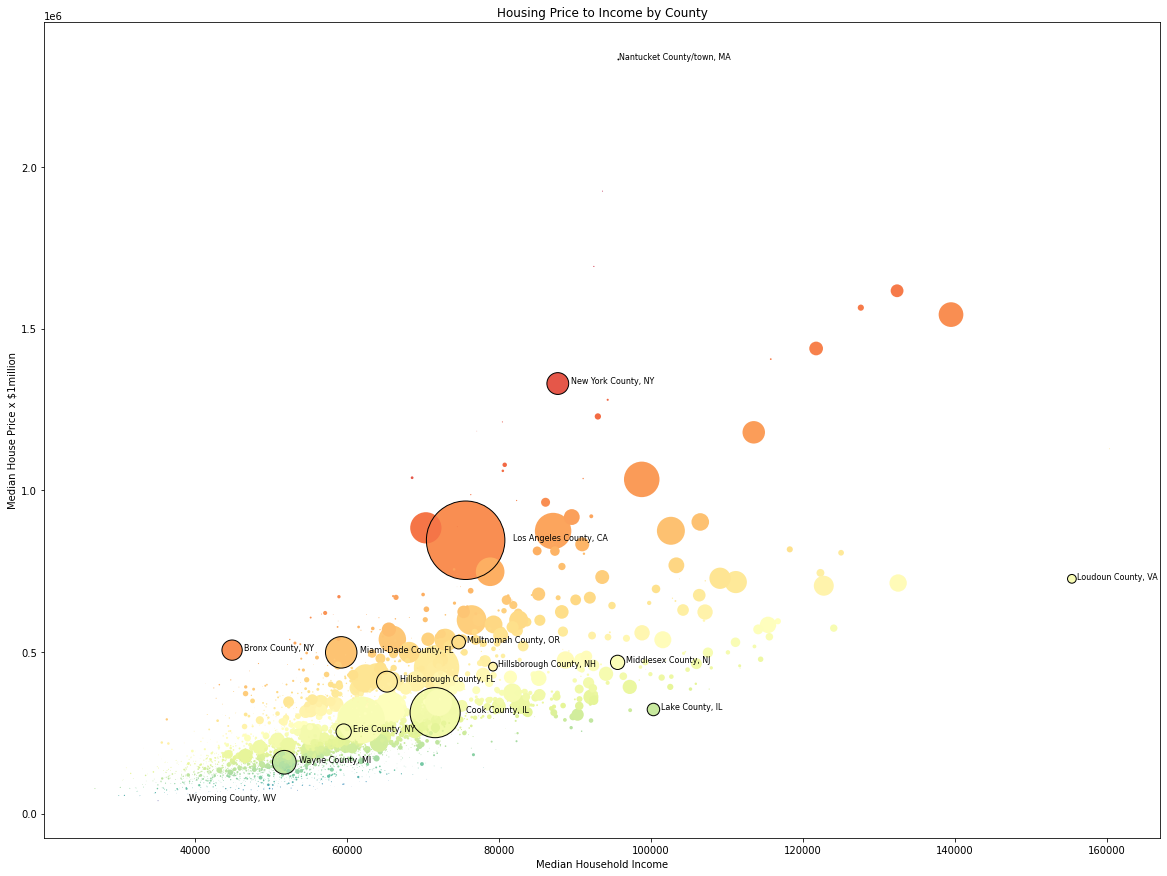

In [413]:
#Calculate value arrays to use for colors and sizes
colors = merged3["Price_Income_Ratio"].apply(lambda x: math.log((1/x)))
sizes = (merged3["Population"])**1.4/1000000

# Create initial graph
plt.rcParams["figure.figsize"] = (20,15)
plt.scatter(merged3['Income'], merged3['House_Price'], c=colors, cmap='Spectral', s=sizes, edgecolors="None")
plt.xlabel('Median Household Income')
plt.ylabel('Median House Price x $1million')
plt.title('Housing Price to Income by County')

# Add selected counties to list after a validity check
county_list = []
county_names = ['Los Angeles County, CA', 'Cook County, IL', 'Lake County, IL', 'Middlesex County, NJ', 'New York County, NY', 'Miami-Dade County, FL',   'Wayne County, MI', 'Hillsborough County, FL',  'Bronx County, NY', 'Hillsborough County, NH', 'Loudoun County, VA', 'Erie County, NY', 'Multnomah County, OR', 'Nantucket County/town, MA', 'Wyoming County, WV']
for row in merged3.index: 
    if merged3.iloc[row]["Area_name"] in county_names:
        county_list.append(row)
        
# Annotate selected counties
for i in county_list:
    plt.annotate(merged3.iloc[i]['Area_name'], (merged3.iloc[i]['Income']+(math.sqrt(sizes[i])*80), merged3.iloc[i]['House_Price']+math.sqrt(sizes[i])*20), fontsize=8)
    plt.scatter(merged3.iloc[i]['Income'], merged3.iloc[i]['House_Price'], s=sizes[i], c='None', edgecolor='black')

plt.savefig('Price_to_Income_scatter1.png')


Generate Regression Model

In [414]:
X = merged3[["Income","Population","Property_Tax", "STNAME"]]
y = merged3[["House_Price"]]

# Create the linear regression model
model = LinearRegression()

# Create dummy variables for the categorical features "Rural_urban" and "STNAME"
#X = pd.get_dummies(X, columns=["Rural_urban"])
X = pd.get_dummies(X, columns=["STNAME"])

# Fit the model to the data
model.fit(X, y)

# Make predictions using the model
y_pred = model.predict(X)





In [415]:
# Add a constant to the predictor variables
X = sm.add_constant(X)

# Fit the model using the OLS (ordinary least squares) method
model = sm.OLS(y, X).fit()

# Print the summary statistics
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            House_Price   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.746
Method:                 Least Squares   F-statistic:                     158.0
Date:                Tue, 24 Jan 2023   Prob (F-statistic):               0.00
Time:                        03:59:52   Log-Likelihood:                -36232.
No. Observations:                2840   AIC:                         7.257e+04
Df Residuals:                    2786   BIC:                         7.289e+04
Df Model:                          53                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [416]:
plt.rcParams["figure.figsize"] = (10,6)

Plot Regression Model

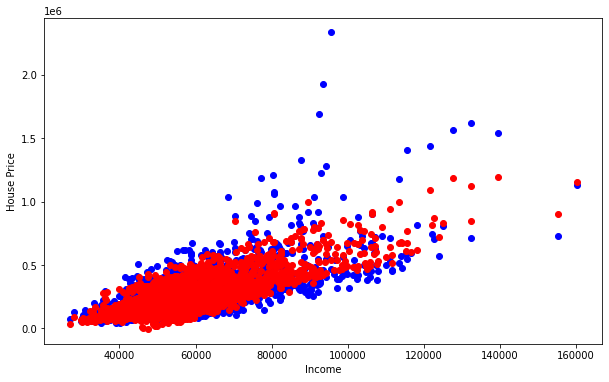

In [417]:
# Plot the data and the predictions
plt.scatter(X["Income"], y, color='b')
plt.scatter(X["Income"], y_pred, color='r')
plt.xlabel("Income")
plt.ylabel("House Price")
plt.show()


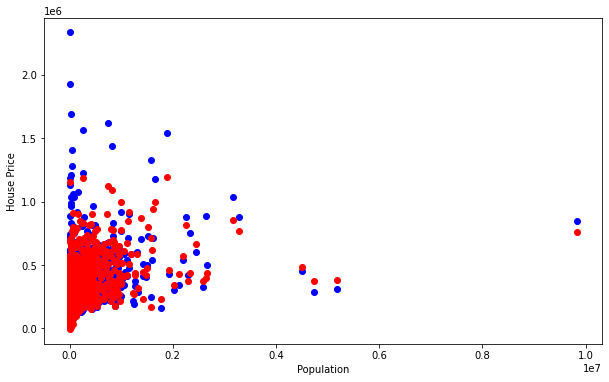

In [418]:

plt.scatter(X["Population"], y, color='b')
plt.scatter(X["Population"], y_pred, color='r')
plt.xlabel("Population")
plt.ylabel("House Price")
plt.show()

Text(0, 0.5, 'Residuals')

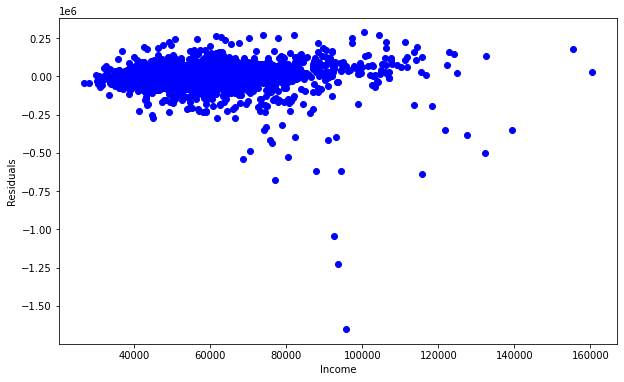

In [419]:
# Calculate the residuals
residuals = y_pred - y

# Plot the residuals
plt.scatter(X["Income"], residuals, color = 'b')
plt.xlabel("Income")
plt.ylabel("Residuals")
#plt.show()



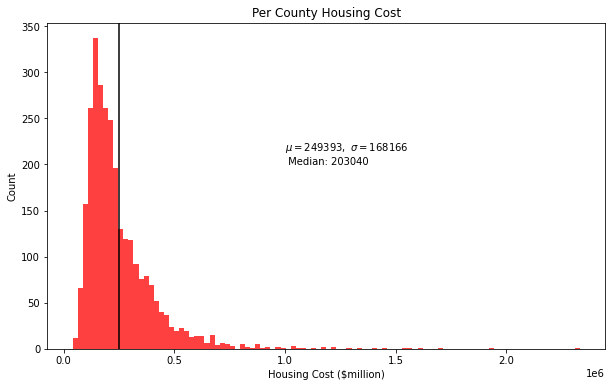

In [420]:
# Per County Housing Cost
plt.hist(merged3["House_Price"], 100, facecolor='r', alpha=.75)
plt.xlabel('Housing Cost ($million)')
plt.ylabel('Count')
plt.title('Per County Housing Cost')

plt.axvline(HP_mean, color='black')
txt = f'$\mu={HP_mean:.0f},\ \sigma={HP_SD:.0f}$\n Median: {HP_50:.0f}'
plt.text(1000000, 200, txt)

plt.savefig('House_cost.png')
plt.show()

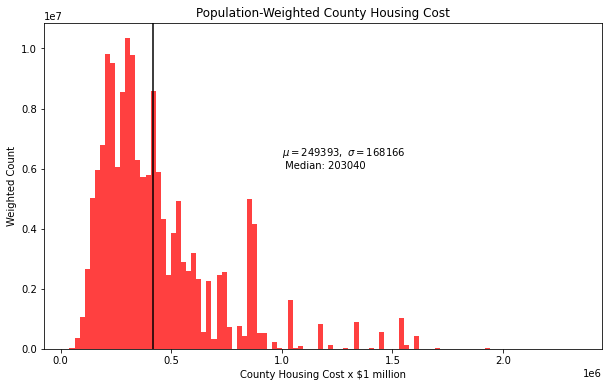

In [421]:
plt.hist(merged3["House_Price"], 100, facecolor='r', alpha=.75, weights=merged3["Labor_Force"])
plt.xlabel('County Housing Cost x $1 million')
plt.ylabel('Weighted Count')
plt.title('Population-Weighted County Housing Cost')

plt.axvline(HP_Wmean, color='black')
txt = f'$\mu={HP_mean:.0f},\ \sigma={HP_SD:.0f}$\n Median: {HP_50:.0f}'
plt.text(1000000, 6000000, txt)

plt.savefig('House_cost_weighted')
plt.show()

Plot Histogram of Price-to-Income Ratios

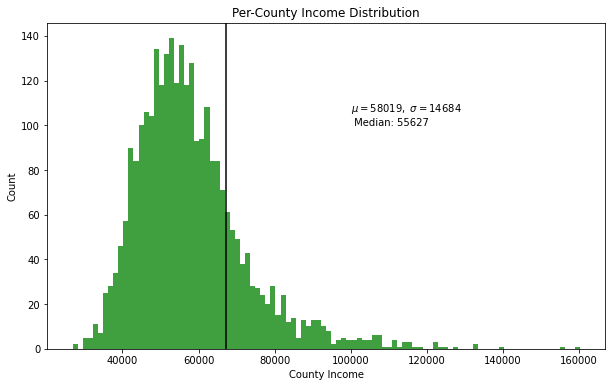

In [422]:
plt.hist(merged3["Income"], 100, facecolor='g', alpha=.75)
plt.xlabel('County Income')
plt.ylabel('Count')
plt.title('Per-County Income Distribution')
plt.axvline(US_MHI, color='black')
txt = f'$\mu={INC_mean:.0f},\ \sigma={INC_SD:.0f}$\n Median: {INC_50:.0f}'
plt.text(100000, 100, txt)
plt.savefig('Income.png')
plt.show()

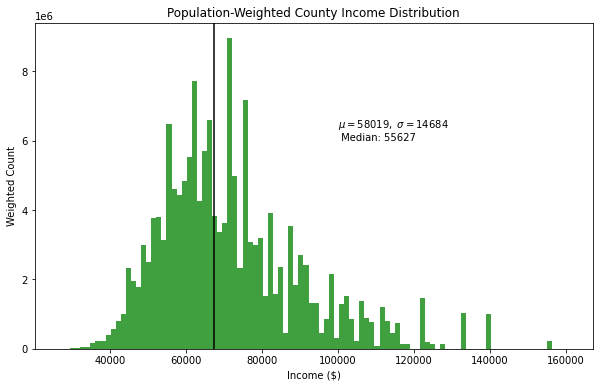

In [423]:
plt.hist(merged3["Income"], 100, facecolor='g', alpha=.75, weights=merged3["Labor_Force"])
plt.xlabel('Income ($)')
plt.ylabel('Weighted Count')
plt.title('Population-Weighted County Income Distribution')
plt.axvline(US_MHI, color='black')
txt = f'$\mu={INC_mean:.0f},\ \sigma={INC_SD:.0f}$\n Median: {INC_50:.0f}'
plt.text(100000, 6000000, txt)
plt.savefig('Income_weighted.png')
plt.show()

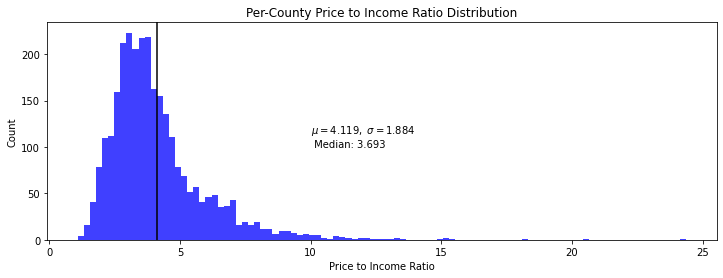

In [424]:
plt.rcParams["figure.figsize"] = (12,4)

plt.hist(merged3[PIR], 100, facecolor='b', alpha=.75)


plt.xlabel('Price to Income Ratio')
plt.ylabel('Count')
plt.title('Per-County Price to Income Ratio Distribution')
plt.axvline(PIR_mean, color='black')
#plt.axvline(PIR_50, color='black')
#plt.axvline(PIR_75, color='black')


txt = f'$\mu={PIR_mean:.3f},\ \sigma={PIR_SD:.3f}$\n Median: {PIR_50:.3f}'
plt.text(10, 100, txt)
plt.savefig('PIR.png')
plt.show()

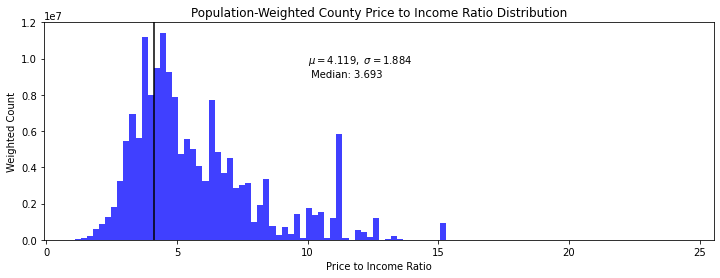

In [425]:
plt.hist(merged3[PIR], 100, facecolor='b', alpha=.75, weights=merged3["Labor_Force"])


plt.xlabel('Price to Income Ratio')
plt.ylabel('Weighted Count')
plt.title('Population-Weighted County Price to Income Ratio Distribution')
plt.axvline(PIR_mean, color='black')
#plt.axvline(PIR_50, color='black')
#plt.axvline(PIR_75, color='black')
txt = f'$\mu={PIR_mean:.3f},\ \sigma={PIR_SD:.3f}$\n Median: {PIR_50:.3f}'
plt.text(10, 9000000, txt)
plt.savefig('PIR_weighted.png')
plt.show()

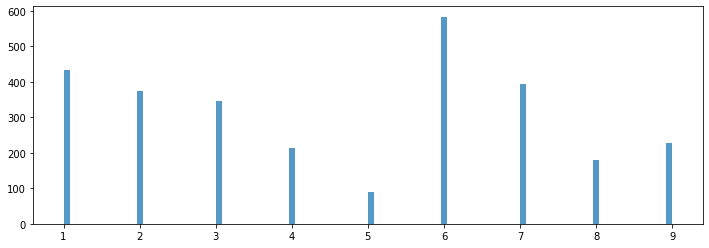

In [426]:
n, bins, patches = plt.hist(merged3["Rural_urban"], 100, alpha=.75)